In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR   = Path("../data/processed")
RAW_FILE   = DATA_DIR / "raw_macro_monthly.csv"
OUT_FILE   = DATA_DIR / "macro_zscores_monthly.csv"

# hyper-params
LOOKBACK_M = 12      # annual Δ
ROLL_M     = 120     # 10-year window
CLIP_Z     = 3       # winsorise at ±3σ

In [2]:
raw_macro = (
    pd.read_csv(RAW_FILE, index_col=0, parse_dates=True)
      .sort_index()
)

print(raw_macro.shape)
raw_macro.head()

(1169, 8)


,sp500,copper,oil,policy_rate,dgs10,yield_curve,market_vol,stock_bond_corr
1928-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-02-29,NaN,NaN,NaN,NaN,NaN,NaN,0.107025,NaN
1928-03-31,NaN,NaN,NaN,NaN,NaN,NaN,0.115021,NaN
1928-04-30,NaN,NaN,NaN,NaN,NaN,NaN,0.162668,NaN
1928-05-31,NaN,NaN,NaN,NaN,NaN,NaN,0.167288,NaN


In [3]:
(
    raw_macro.notna()
             .apply(lambda col: col.idxmax())
             .to_frame('first_date')
)

,first_date
sp500,1963-01-31
copper,1960-01-31
oil,1946-01-31
policy_rate,1934-01-31
dgs10,1962-01-31
yield_curve,1962-01-31
market_vol,1928-02-29
stock_bond_corr,1966-01-31


In [4]:
# 4.1 annual difference
diff = raw_macro.diff(LOOKBACK_M)

# 4.2 rolling μ and σ (unbiased σ not needed for z anyway)
mu  = diff.rolling(ROLL_M, min_periods=ROLL_M).mean()
std = diff.rolling(ROLL_M, min_periods=ROLL_M).std(ddof=0)

# 4.3 z-score + winsorise
z = ((diff - mu) / std).clip(-CLIP_Z, CLIP_Z)

# 4.4 drop rows that still have NaNs in *any* of the seven factors
z = z.dropna(how="any")
print("First full-row date:", z.index.min())
print("Final shape:", z.shape)

First full-row date: 1976-12-31 00:00:00
Final shape: (577, 8)


array([[<Axes: title={'center': 'sp500'}>,
        <Axes: title={'center': 'copper'}>,
        <Axes: title={'center': 'oil'}>],
       [<Axes: title={'center': 'policy_rate'}>,
        <Axes: title={'center': 'dgs10'}>,
        <Axes: title={'center': 'yield_curve'}>],
       [<Axes: title={'center': 'market_vol'}>,
        <Axes: title={'center': 'stock_bond_corr'}>, <Axes: >]],
      dtype=object)

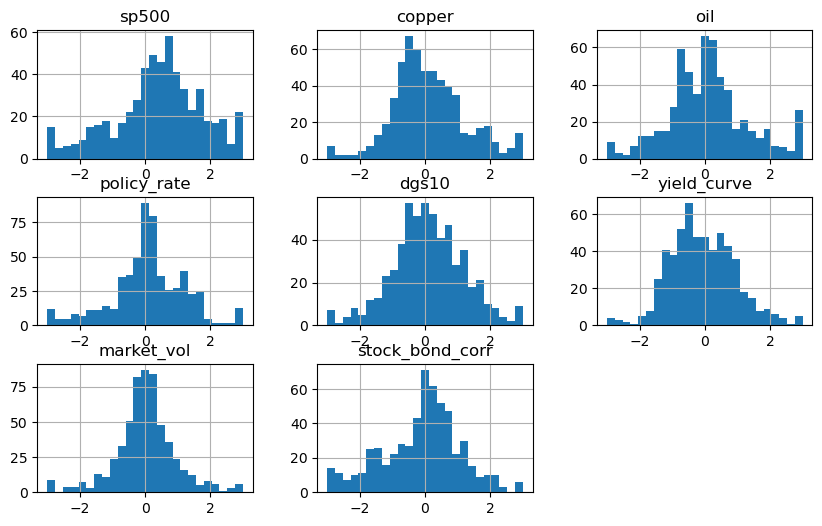

In [5]:
# histogram for a quick eyeball
z.hist(figsize=(10,6), bins=25, layout=(3,3))

In [6]:
# mean and std should be ~0 and ~1 after clipping
z.describe().loc[['mean','std','min','max']]

,sp500,copper,oil,policy_rate,dgs10,yield_curve,market_vol,stock_bond_corr
mean,0.402758,0.115418,0.094441,0.101179,0.093524,-0.064298,0.011499,-0.097370
std,1.359797,1.103941,1.223687,1.125970,1.093258,1.009392,0.940199,1.191556
min,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [8]:
z.to_csv(OUT_FILE)
print("➡  saved to", OUT_FILE.resolve())

➡  saved to /Users/akash009/rl-asset-allocation/data/processed/macro_zscores_monthly.csv
